In [86]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [87]:
data_path = '../../data/postprocessed/PC/'

mapping_table = {
    'NN50PercLeNet5': 'LeNet5',
    'NN50Percmnasnet05': 'MnasNet',
    'NN50Percmobilenetv2': 'MobileNetV2',
    'NN50Percresnet18': 'ResNet18',
    'gpuburn5min': 'GPU-burn'
}

data_sheet = pd.DataFrame()
for csv_name in [file for file in os.listdir(data_path) if (('NN50Perc' in file or '5min' in file) and not 'telemetry' in file)]:
    csv_full_path = os.path.join(data_path, csv_name)
    print(csv_full_path)
    df = pd.read_csv(csv_full_path)
    df['Range'] = int(csv_name.split('_')[1].split('.')[0])
    df['App_name'] = mapping_table[csv_name.split('_')[0]]
    df['progress'] = (df['session_id'] - df['session_id'].min()) / (df['session_id'].max() - df['session_id'].min()) * 100
    # print(df[df.isna()])
    data_sheet=pd.concat([data_sheet, df], ignore_index=True)

../../data/postprocessed/PC/NN50PercLeNet5_1.csv
../../data/postprocessed/PC/gpuburn5min_1.csv
../../data/postprocessed/PC/NN50Percresnet18_1.csv
../../data/postprocessed/PC/NN50Percmnasnet05_1.csv
../../data/postprocessed/PC/NN50Percmobilenetv2_1.csv


## Fixing the set of computed metrics across all the experiments

### I want to check if the number of Kernel Injection (Range) affects the number of run sessions.

In [88]:
for label in sorted(data_sheet['Range'].unique()):
    print("--------------------------------------------------------------------")
    print(f'Number of times a kernel is executed for metric computation: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['Range']==label])}")

--------------------------------------------------------------------
Number of times a kernel is executed for metric computation: 1
Instances: 31794


### Apparently not

### Thus, it must be dependent only on the application complexity

In [89]:
for label in mapping_table.values():
    print("--------------------------------------------------------------------")
    print(f'App name: {label}') 
    print(f"Instances: {len(data_sheet[data_sheet['App_name']==label])}")

--------------------------------------------------------------------
App name: LeNet5
Instances: 462
--------------------------------------------------------------------
App name: MnasNet
Instances: 3444
--------------------------------------------------------------------
App name: MobileNetV2
Instances: 17325
--------------------------------------------------------------------
App name: ResNet18
Instances: 5922
--------------------------------------------------------------------
App name: GPU-burn
Instances: 4641


In [90]:
data_sheet.isna().sum()

session_id          0
duration_ms         0
location            0
metric_name         0
rollup_operation    0
range_name          0
metric_value        0
Range               0
App_name            0
progress            0
dtype: int64

### Considerations
1. Complexity does not imply stress
2. I think that the complexity is due also to the number of kernels that the application comprises

TODO: look at Future works

In [91]:
data_sheet['rollup_operation'].unique()
# It is a useless column, we can drop it
data_sheet = data_sheet.drop('rollup_operation', axis=1)

### Available data

In [92]:
location_mapping={
    'lts': 'L2 Cache',
    'sm': 'Streaming Multiprocessor',
    'smsp': 'Streaming Multiprocessor Subpartition',
    'sys': 'System (aggregated info)',
    'dram': 'Dynamic RAM'
}
data_sheet['location'].unique()

array(['sm', 'sys', 'smsp', 'dram', 'lts'], dtype=object)

In [93]:
data_sheet['HR_location'] = data_sheet['location'].map(location_mapping)
data_sheet.drop('location', axis=1, inplace=True)

In [94]:
metric_event_mapping= {
    'cycles_active': 'Active cycles',
    'warps_active': 'Active warps',
    'inst_executed_op_generic_atom_dot_alu': 'Atomic ALU operations',
    'cycles_elapsed': 'Total elapsed cycles',
    'inst_executed_op_generic_atom_dot_cas': 'CAS atomic operatiions on global memory',
    'inst_executed_op_global_red': 'Global reduction',
    'inst_executed': 'Executed instructions',
    'inst_executed_pipe_fma': 'Executed FMA instructions',
    'inst_executed_pipe_fp64': 'Executed Double Precision instructions',
    'inst_issued': 'Issued instructions',
    't_sectors_op_read_lookup_miss': 'miss',
    'warps_launched': 'Executing warps',
    'thread_inst_executed': 'Executed thread instructions',
    'inst_executed_op_local_st': 'Executed instructions involving local memory store (write)',
    'inst_executed_op_local_ld': 'Executed instruction involving local memory load (read)',
    'inst_executed_op_global_st': 'Executed instructions involving global memory store (write)',
    'inst_executed_op_global_ld': 'Executed instructions involving global memory load (read)',
    'sectors_write':'Written memory partition',
    'sectors_read':'Read memory partition'
}
data_sheet['metric_name'].unique()

array(['cycles_active', 'warps_active',
       'inst_executed_op_generic_atom_dot_alu', 'cycles_elapsed',
       'sectors_read', 'sectors_write',
       'inst_executed_op_generic_atom_dot_cas',
       'inst_executed_op_global_red', 'inst_executed',
       'inst_executed_pipe_fma', 'inst_executed_pipe_fp64', 'inst_issued',
       't_sectors_op_read_lookup_miss', 'warps_launched',
       'thread_inst_executed', 'inst_executed_op_local_st',
       'inst_executed_op_local_ld', 'inst_executed_op_global_st',
       'inst_executed_op_global_ld'], dtype=object)

In [95]:
data_sheet['HR_metric_name'] = data_sheet['metric_name'].map(metric_event_mapping)
data_sheet.drop('metric_name', axis=1, inplace=True)

### Let's fix for a second the Number of times a kernel is executed for metric computations to 1

In [96]:
data_sheet['Range'].dtypes

dtype('int64')

In [97]:
data_sheet_1 = data_sheet[data_sheet['Range']==1]

### Regardless of the application I want to see the correlation within the columns

In [98]:
df_l2_1 = data_sheet_1[data_sheet_1['HR_location']=='L2 Cache']
df_sm_1 = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor']
df_smsp_1 = data_sheet_1[data_sheet_1['HR_location']=='Streaming Multiprocessor Subpartition']
df_sys_1 = data_sheet_1[data_sheet_1['HR_location']=='System (aggregated info)']
df_dram_1 = data_sheet_1[data_sheet_1['HR_location']=='Dynamic RAM']

dfs = {
    'L2 Cache': df_l2_1, 
    'Streaming Multiprocessor': df_sm_1, 
    'Streaming Multiprocessor Subpartition': df_smsp_1, 
    'System (Aggregated info)': df_sys_1, 
    'Dynamic RAM': df_dram_1
    }

In [99]:
df_pivot_l2_1 = df_l2_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sm_1 = df_sm_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_smsp_1 = df_smsp_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_sys_1 = df_sys_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

df_pivot_dram_1 = df_dram_1.pivot_table(
    index=["session_id", "HR_location", "range_name", "Range", "App_name"],
    columns="HR_metric_name",
    values="metric_value"
).reset_index()

pivot_dfs = {
    'L2 Cache': df_pivot_l2_1, 
    'Streaming Multiprocessor': df_pivot_sm_1, 
    'Streaming Multiprocessor Subpartition': df_pivot_smsp_1, 
    'System (Aggregated info)': df_pivot_sys_1, 
    'Dynamic RAM': df_pivot_dram_1
    }

In [100]:
metric_full_name = data_sheet_1['HR_location'] +' '+ data_sheet_1['HR_metric_name']
metric_full_name

0                   Streaming Multiprocessor Active cycles
1                   System (aggregated info) Active cycles
2                    Streaming Multiprocessor Active warps
3        Streaming Multiprocessor Subpartition Atomic A...
4            Streaming Multiprocessor Total elapsed cycles
                               ...                        
31789    Streaming Multiprocessor Subpartition Executed...
31790    Streaming Multiprocessor Subpartition Executed...
31791    Streaming Multiprocessor Subpartition Executed...
31792    Streaming Multiprocessor Subpartition Executed...
31793    Streaming Multiprocessor Subpartition Executed...
Length: 31794, dtype: object

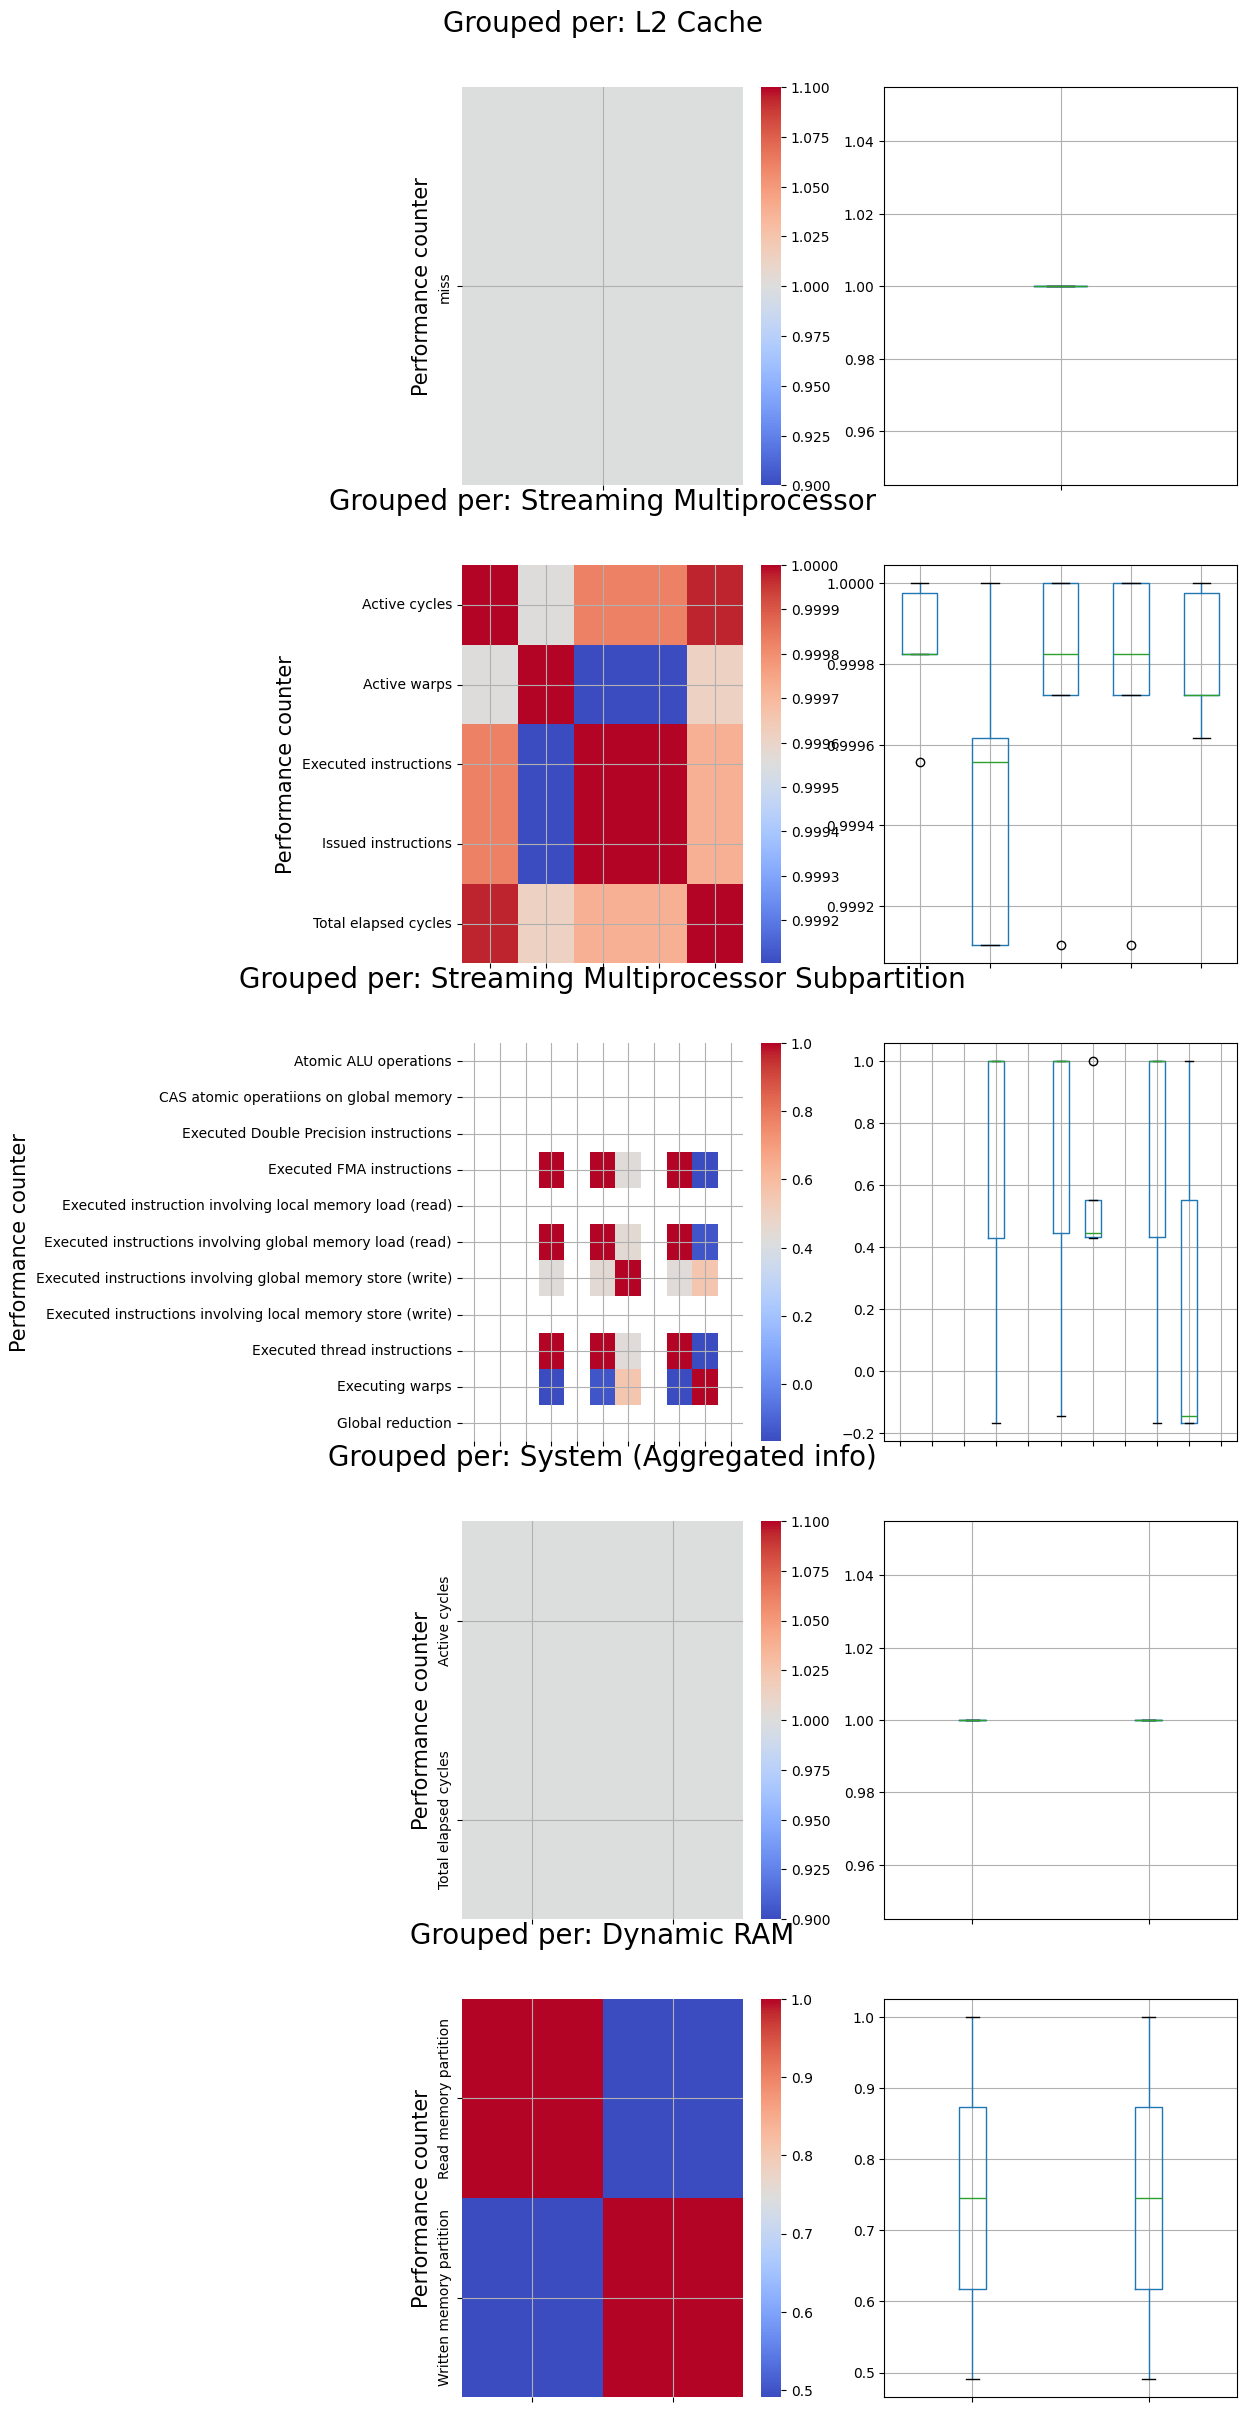

In [101]:
fig, ax = plt.subplots(5,2,figsize=(10,30))
for pivot_df_idx in range(len(list(pivot_dfs.values()))):
    HR_location = list(pivot_dfs.keys())[pivot_df_idx]
    # print(pivot_dfs[HR_location].select_dtypes(include=['float64']))
    # data_to_corr = pivot_dfs[HR_location][cols_to_corr]
    # target_data = data_to_corr.drop('HR_location', axis = 1)
    data_to_corr = pivot_dfs[HR_location].select_dtypes(include=['float64'])
    matrix = data_to_corr.corr()
    matrix.boxplot(ax=ax[pivot_df_idx][1])
    sns.heatmap(matrix, annot=False, cmap='coolwarm', ax=ax[pivot_df_idx][0])
    ax[pivot_df_idx][0].set_title(f"Grouped per: {HR_location}", fontsize=20, pad=40)
    ax[pivot_df_idx][0].grid()
    ax[pivot_df_idx][0].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][0].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx][1].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].tick_params(axis='x', labelrotation=90, labelsize=13)
    ax[pivot_df_idx][0].set_xticklabels([])
    ax[pivot_df_idx][1].set_xticklabels([])
    ax[pivot_df_idx][0].set_xlabel('')

### Stress evaluation

In [102]:
reverse_location_mapping={
    'L2 Cache': 'lts',
    'Streaming Multiprocessor': 'sm',
    'Streaming Multiprocessor Subpartition': 'smsp',
    'System (Aggregated info)': 'sys',
    'Dynamic RAM': 'dram'
}

In [103]:
# hue_order = ['Backpropagation algorithm', 'Gaussian Elimination', 'Lenet5', 'GPU-burn']

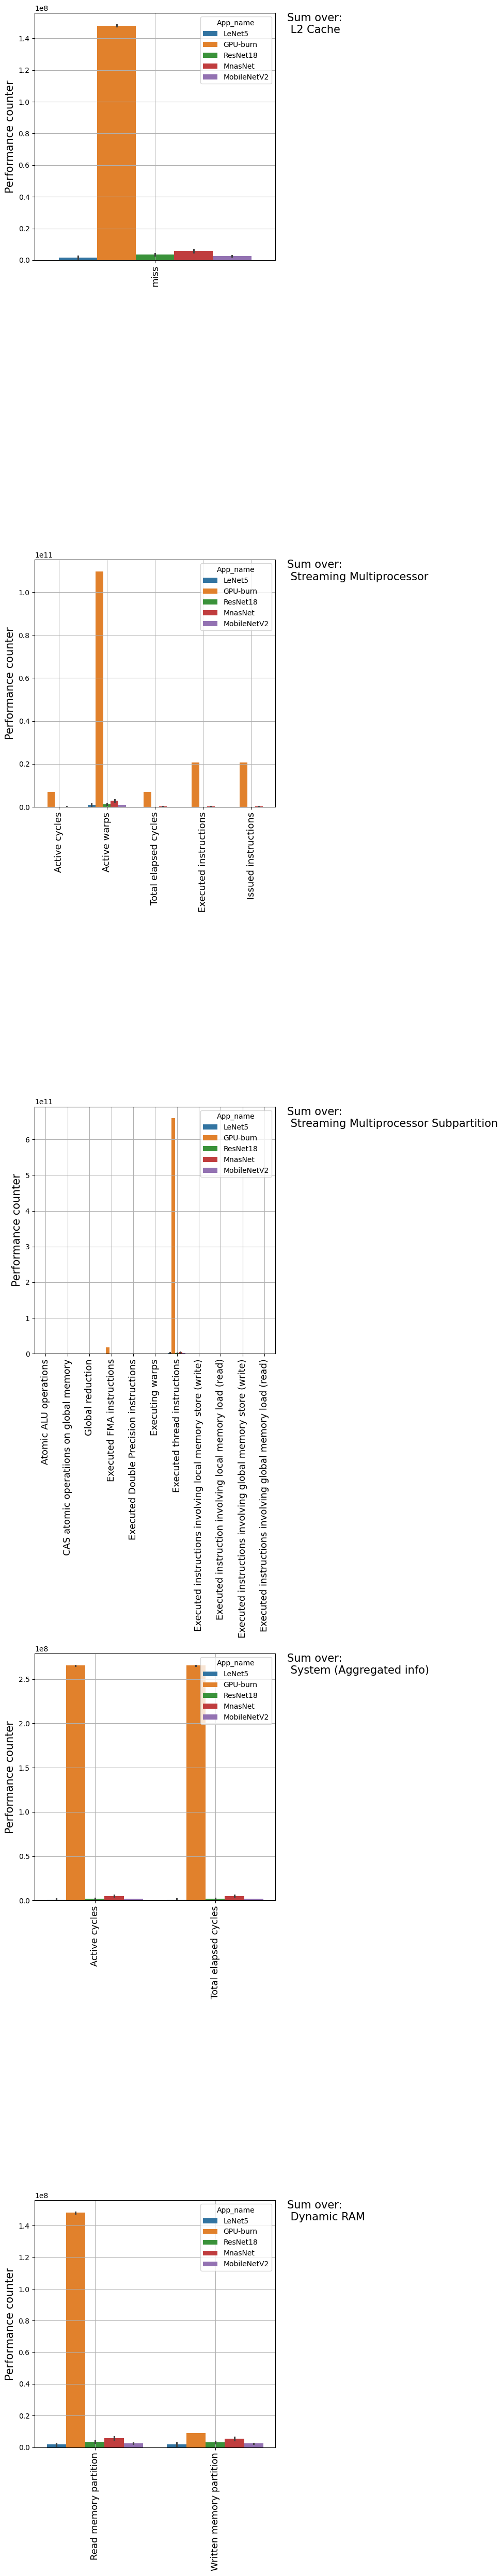

In [104]:
fig, ax = plt.subplots(5,1,figsize=(10,50))
for pivot_df_idx in range(len(list(dfs.values()))):
    HR_location = list(dfs.keys())[pivot_df_idx]
    # data_to_corr = dfs[HR_location].select_dtypes(include=['float64'])
    sns.barplot(data = dfs[HR_location], x='HR_metric_name', y='metric_value', hue='App_name', ax = ax[pivot_df_idx])
    # ax[pivot_df_idx].set_title(f"Grouped per: {HR_location}", fontsize=20, loc='right')
    ax[pivot_df_idx].text(1.05, 1.0, f'Sum over: \n {HR_location}', transform=ax[pivot_df_idx].transAxes,
         ha='left', va='top', fontsize=15)
    ax[pivot_df_idx].grid()
    # ax[pivot_df_idx].set_yscale('log')
    ax[pivot_df_idx].set_xlabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].set_ylabel('Performance counter', fontsize=15)
    ax[pivot_df_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[pivot_df_idx].set_xticklabels([])
    ax[pivot_df_idx].set_xlabel('')
plt.tight_layout()

In [105]:
dfs['L2 Cache'].columns

Index(['session_id', 'duration_ms', 'range_name', 'metric_value', 'Range',
       'App_name', 'progress', 'HR_location', 'HR_metric_name'],
      dtype='object')

In [106]:
data_sheet['HR_location'].unique()

array(['Streaming Multiprocessor', 'System (aggregated info)',
       'Streaming Multiprocessor Subpartition', 'Dynamic RAM', 'L2 Cache'],
      dtype=object)

In [107]:
data_sheet.columns

Index(['session_id', 'duration_ms', 'range_name', 'metric_value', 'Range',
       'App_name', 'progress', 'HR_location', 'HR_metric_name'],
      dtype='object')

/tmp/ipykernel_21497/2248377520.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_21497/2248377520.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_21497/2248377520.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
/tmp/ipykernel_21497/2248377520.py:13: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[metric_idx].set_yscale('log')
/tmp/ipykernel_21497/2248377520.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci

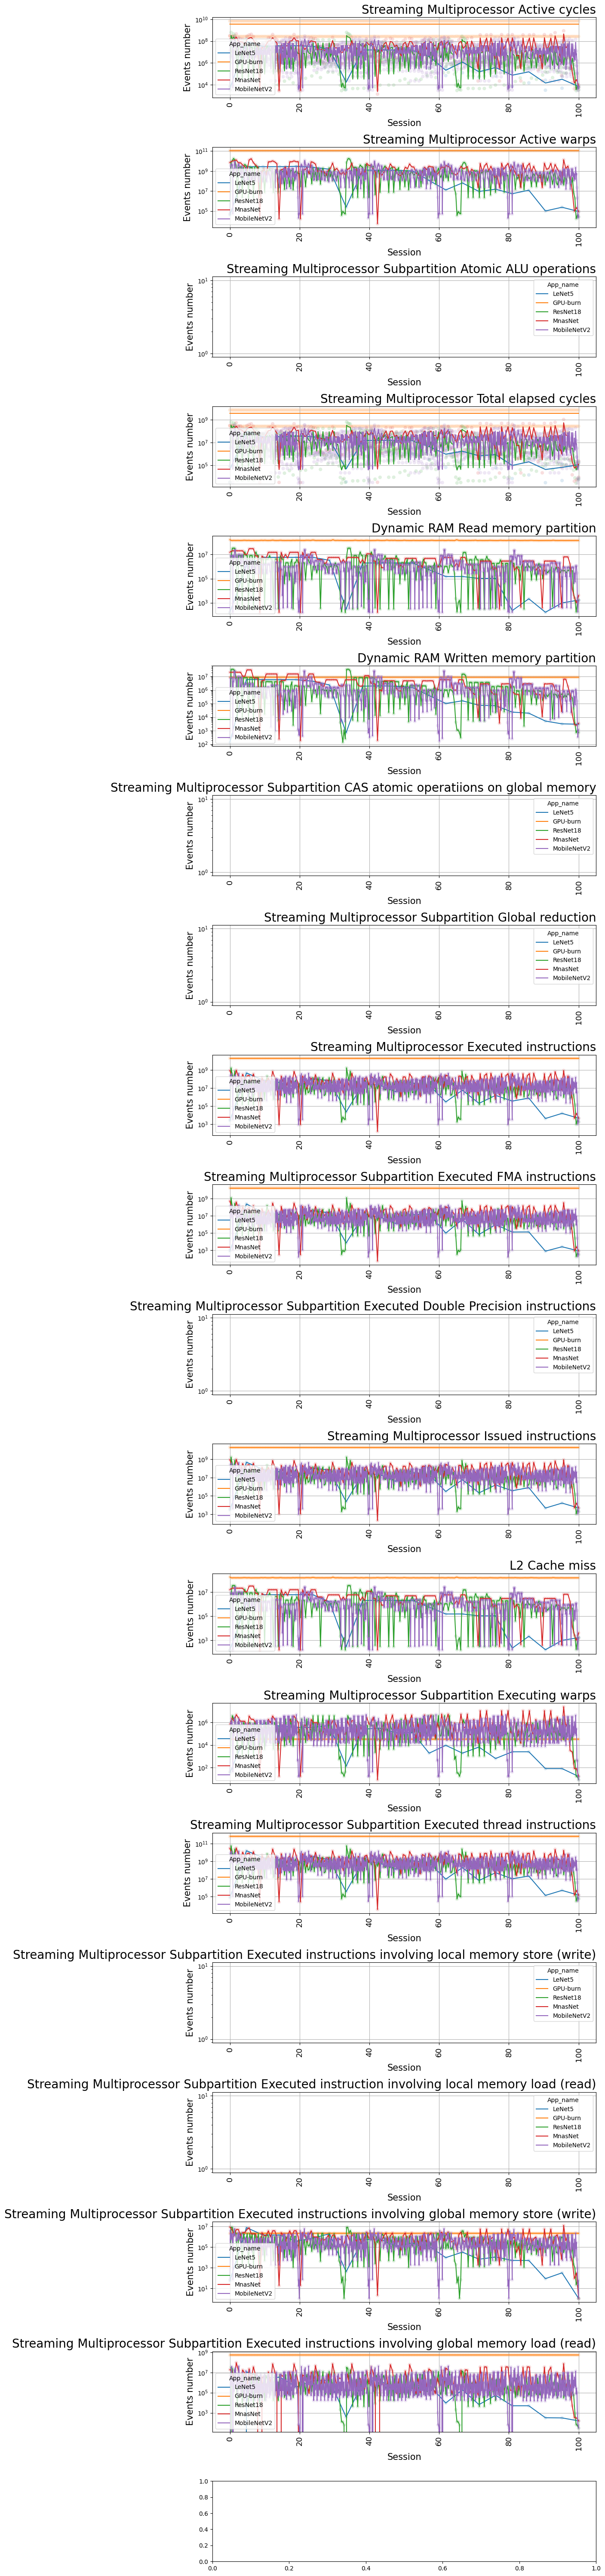

In [108]:
fig, ax = plt.subplots(20,1,figsize=(10,60))

for metric_idx in range(len(data_sheet_1['HR_metric_name'].unique())):
    metric_name = data_sheet_1['HR_metric_name'].unique()[metric_idx]
    data = data_sheet_1[data_sheet_1['HR_metric_name'] == metric_name]
    HR_location=data['HR_location'].unique()[0]
    sns.lineplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], ci=False)
    sns.scatterplot(data = data, x='progress', y='metric_value', hue='App_name', ax = ax[metric_idx], alpha=0.15, legend=False)
    ax[metric_idx].set_title(f"{HR_location} {metric_name}", fontsize=20, loc='right')
    # ax[metric_idx].text(1.05, 1.0, f'Grouped per: \n {HR_location}', transform=ax[metric_idx].transAxes,
    #      ha='left', va='top', fontsize=15)
    ax[metric_idx].grid()
    ax[metric_idx].set_yscale('log')
    ax[metric_idx].set_xlabel('Session', fontsize=15)
    ax[metric_idx].set_ylabel('Events number', fontsize=15)
    ax[metric_idx].tick_params(axis='x', labelrotation=90, labelsize=13)
    # ax[df_idx].set_xticklabels([])
plt.tight_layout()

Text(0.5, 0, '')

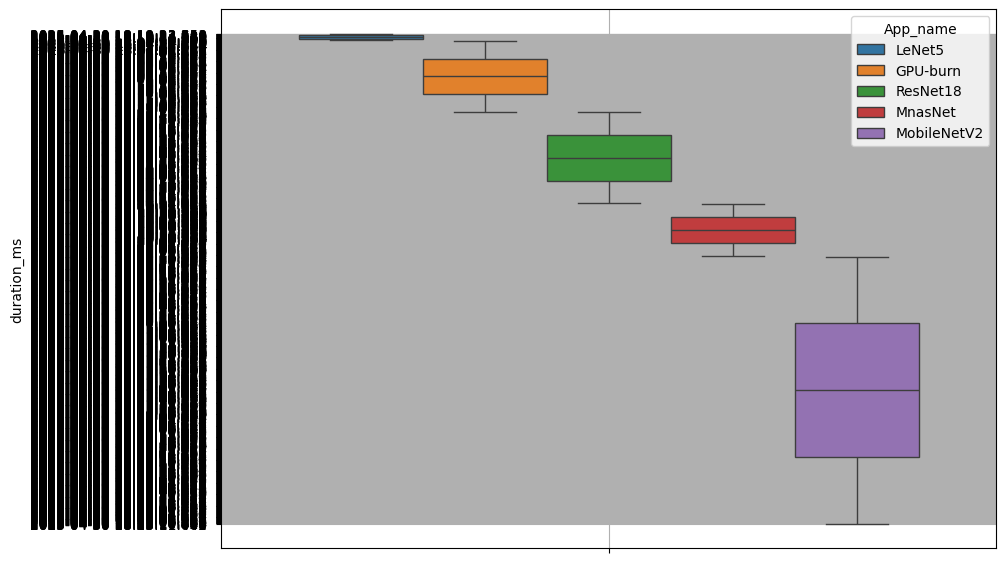

In [82]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
HR_location=data['HR_location'].unique()[0]
sns.boxplot(data, y='duration_ms', hue='App_name', ax = ax)
ax.grid()
ax.set_xlabel('', fontsize=15)

### Final remarks

### Future works
1. Use the correlation ID to correlate instructions with SASS code 
2. Explore the possibility to use sass_source_map or sass_metrics
3. 

### Metrics description
- SM Active cycles: Per ogni SM (in media) how many times there is at least an active warp?
- SM Active warps: Per ogni SM (in media) how many warps are active?